In [1]:
import torch
import torch.nn as nn

def kr_loss(y_pred, y_true, reduction='mean', epsilon=1e-6):
    # assumes y_true is in {0, 1}^n
    sign = 2 * y_true - 1
    # this is the same as torch.mean(y_pred[y_true == 1]) - torch.mean(y_pred[y_true == 0])
    # perhaps negative labels should be weighted less?
    # kr = y_pred * sign
    # return reduce_loss(kr, reduction=reduction)
    batch_size = y_true.shape[0]
    # Transform y_true into {1, 0} values
    S1 = (y_true==1).float()
    num_elements_per_class = S1.sum(axis=0)

    pos = S1 / (num_elements_per_class + epsilon)
    neg = (1 - S1) / (batch_size - num_elements_per_class + epsilon)
    # Since element-wise KR terms are averaged by loss reduction later on, it is needed
    # to multiply by batch_size here.
    # In binary case (`y_true` of shape (batch_size, 1)), `tf.reduce_mean(axis=-1)`
    # behaves like `tf.squeeze()` to return element-wise loss of shape (batch_size, ).
    kr = torch.mean(batch_size * y_pred * (pos - neg), axis=-1)
    return reduce_loss(kr, reduction=reduction)


def hinge_loss(y_pred, y_true, margin=1.0, reduction='mean'):
    # assumes y_true is in {0, 1}^n
    sign = 2 * y_true - 1
    hinge = torch.relu(margin - sign * y_pred)
    return reduce_loss(hinge, reduction=reduction)


def label_dist(x, y, p=2, compute_mode='accurate'):
    """Compute the distances between each point x and its nearest neighbor from each class.
    Assumes that the labels are in {0, 1}^c.

    Args:
        x (torch.Tensor): Input tensor. Has shape (n, d).
        y (torch.Tensor): Labels. Has shape (n, c).

    Returns:
        torch.Tensor: Distances. Has shape (n, c).
    """
    if compute_mode == 'accurate':
        dist = torch.cdist(x, x, p=p, compute_mode='donot_use_mm_for_euclid_dist')
    elif compute_mode == 'fast':
        dist = torch.cdist(x, x, p=p, compute_mode='use_mm_for_euclid_dist')
    else:
        raise ValueError(f"Unknown compute_mode: {compute_mode}")
    assert dist.diag().max() == 0, "Diagonal should be zero"
    class_distances = []
    # could be made more efficient but this is fine for now
    for row in range(y.shape[0]):
        d = []
        for i in range(y.shape[1]):
            d.append(torch.amin(dist[row][y[:, i] == 1]).item())
        class_distances.append(d)
    class_distances = torch.tensor(class_distances)
    return class_distances


class KRLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return kr_loss(y_pred, y_true)


class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, y_pred, y_true):
        return hinge_loss(y_pred, y_true, margin=self.margin)


class HKRLoss(nn.Module):
    def __init__(self, margin=1.0, alpha=1.0):
        super().__init__()
        self.margin = margin
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        return - kr_loss(y_pred, y_true) + self.alpha * hinge_loss(y_pred, y_true, margin=self.margin)


class DynamicHingeLoss(nn.Module):
    def __init__(self, margin=1.0, p=2, x=None, y_true=None, d_margins=None, reduction='mean'):
        super().__init__()
        self.margin = margin
        self.p = p
        self.reduction = reduction
        if d_margins is not None:
            self.margin += d_margins
        elif x is not None and y_true is not None:
            self.margin += label_dist(x, y_true, p=self.p)/2
        else:
            raise ValueError('Must provide either d_margins or x and y_true')
            
    def to(self, device):
        self.margin = self.margin.to(device)
        return self

    def forward(self, y_pred, y_true):
        return hinge_loss(y_pred, y_true, margin=self.margin, reduction=self.reduction)


class CELoss(nn.Module):
    def __init__(self, tau=1.0, reduction='mean'):
        super().__init__()
        self.loss = nn.CrossEntropyLoss(reduction=reduction)
        self.tau = tau

    def forward(self, y_pred, y_true):
        return self.loss(self.tau * y_pred, y_true.argmax(dim=1))

def reduce_loss(loss, reduction='mean'):
    if reduction == 'mean':
        return torch.mean(loss)
    elif reduction == 'sum':
        return torch.sum(loss)
    else:
        return loss


In [12]:
from sklearn.datasets import make_moons
import torch
import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from monotonenorm import direct_norm, GroupSort

torch.manual_seed(42)

x, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

y = y.view(-1, 1)
y = torch.cat((1 - y, y), dim=1)

class ModelBase(torch.nn.Module):
    def __init__(self, lipschitz=True, seed=None, width=10):
        if seed is not None: torch.manual_seed(seed)
        super().__init__()
        norm = direct_norm if lipschitz else lambda x, **kwargs: x
        act = GroupSort(width//2) if lipschitz else torch.nn.ReLU()

        self.mlp = torch.nn.Sequential(
            norm(torch.nn.Linear(2, width), kind="two-inf"),
            act,
            norm(torch.nn.Linear(width, width), kind="inf"),
            act,
            norm(torch.nn.Linear(width, 2), kind="inf"))
        self.loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.mlp(x)
    
    def train_loop(self, epochs=2000, lr=0.01, x=x, y=y, x_val=None, y_val=None):
        optimizer = torch.optim.Adam(self.mlp.parameters(), lr=lr)

        pbar = tqdm.trange(epochs)
        for _ in pbar:
            optimizer.zero_grad()
            y_pred = self.mlp(x)
            l = self.loss(y_pred, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                normed_pred = torch.softmax(y_pred, dim=1)
                acc = accuracy(normed_pred, y.long())
                margins = y_pred.diff(dim=1).abs()
                min_margin = torch.min(margins)
                max_margin = torch.max(margins)
                mean_margin = torch.mean(margins)
                metrics = dict(loss=l.item(), acc=acc.item(), ypred=y_pred.mean().item(), 
                min_margin=min_margin.item(), max_margin=max_margin.item(), 
                mean_margin=mean_margin.item())
                if x_val is not None:
                    metrics['acc_val'] = accuracy(torch.softmax(self.mlp(x_val), dim=1), y_val.long())
            pbar.set_postfix(**metrics)
    
    def set_loss(self, loss):
        self.loss = loss


# heatmap of mlp output
def plot_mlp(mlp):
    x1 = torch.linspace(-2, 2, 100)
    x2 = torch.linspace(-2, 2, 100)
    x1, x2 = torch.meshgrid(x1, x2)
    xplot = torch.stack((x1.flatten(), x2.flatten()), dim=1)
    y_pred = mlp(xplot)
    if y_pred.shape[1] > 1:
        y_pred = torch.softmax(y_pred, dim=1).diff(dim=1)
        y_truth = y.argmax(dim=1)
    else: 
        y_pred = torch.sigmoid(y_pred)
        y_truth = y

    plt.figure(figsize=(10, 10))
    # make contour lines thicker
    plt.contourf(x1, x2, y_pred.detach().numpy().reshape(100, 100), cmap='RdBu', alpha=0.5)
    plt.colorbar()
    plt.contour(x1, x2, y_pred.detach().numpy().reshape(100, 100), c="k", linewidths=3)
    plt.scatter(x[:, 0], x[:, 1], c=y_truth, cmap='RdBu', alpha=0.5)
    plt.show()


/tmp/ipykernel_90968/154762308.py:81: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(x1, x2, y_pred.detach().numpy().reshape(100, 100), c="k", linewidths=3)


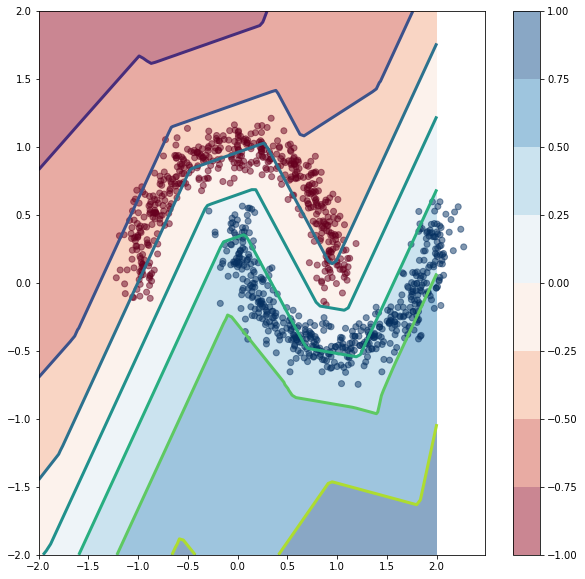

In [13]:
plot_mlp(mlp)

100%|██████████| 3000/3000 [00:07<00:00, 391.30it/s, acc=1, loss=-.481, max_margin=1.6, mean_margin=0.671, min_margin=0.0627, ypred=-.000636]       
/tmp/ipykernel_90968/154762308.py:81: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(x1, x2, y_pred.detach().numpy().reshape(100, 100), c="k", linewidths=3)


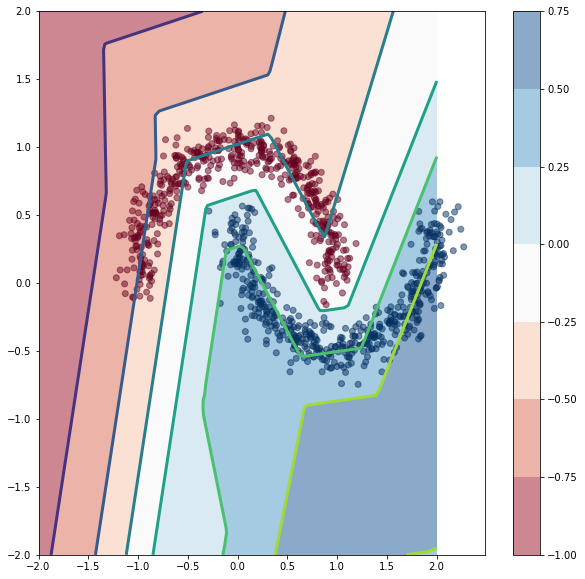

In [16]:
mlp = ModelBase(lipschitz=True)
# loss = DynamicHingeLoss(x=x, y_true=y, p=2, margin=0, reduction='mean')
loss = HKRLoss(margin=0.08, alpha=1000)
# loss = torch.nn.CrossEntropyLoss()
mlp.set_loss(loss)
mlp.train_loop(3000, lr=1e-2)
plot_mlp(mlp)

In [17]:
d_margins_twomoons = label_dist(x, y, p=2)/2
d_margins_twomoons[d_margins_twomoons==0] = float('inf')
d_margins_twomoons[d_margins_twomoons==float('inf')] = d_margins_twomoons.amin(-1)
d_margins_twomoons[0]

tensor([0.1457, 0.1457])

In [18]:
d_margins_twomoons = label_dist(x, y, p=2)/2
d_margins_twomoons[d_margins_twomoons==0]
mlp = ModelBase(lipschitz=True, seed=0)
loss = DynamicHingeLoss(d_margins=d_margins_twomoons, p=2, margin=0, reduction='mean')
mlp.set_loss(loss)
mlp.train_loop(3000, lr=1e-2)

100%|██████████| 3000/3000 [00:07<00:00, 391.02it/s, acc=0.999, loss=0.000368, max_margin=1.4, mean_margin=0.677, min_margin=0.0598, ypred=-.094]    


In [20]:
mlp = ModelBase(lipschitz=True, seed=0)
loss = DynamicHingeLoss(x=x, y_true=y, p=2, margin=0, reduction='mean')
mlp.set_loss(loss)
mlp.train_loop(3000, lr=1e-2)

100%|██████████| 3000/3000 [00:07<00:00, 379.75it/s, acc=0.999, loss=0.000368, max_margin=1.4, mean_margin=0.677, min_margin=0.0598, ypred=-.094]    


/tmp/ipykernel_90968/154762308.py:81: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(x1, x2, y_pred.detach().numpy().reshape(100, 100), c="k", linewidths=3)


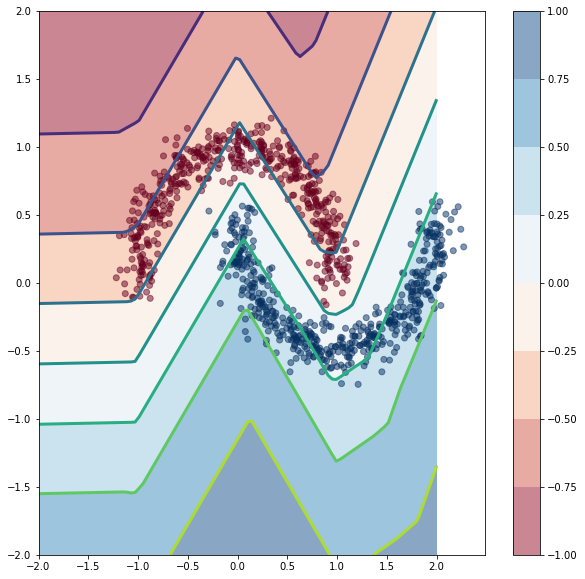

In [21]:
plot_mlp(mlp)

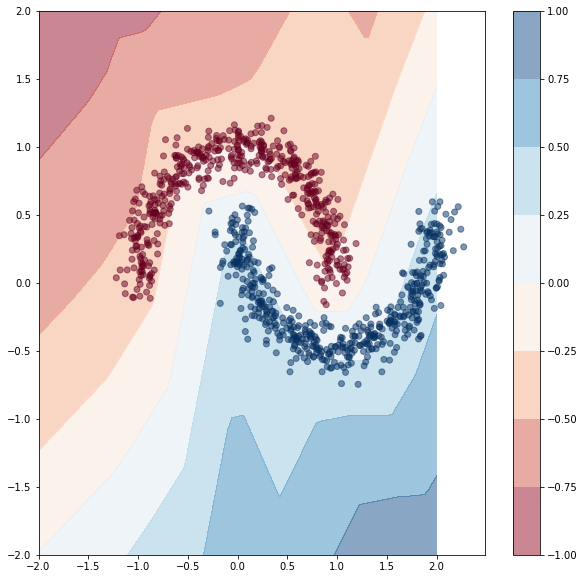

In [208]:
plot_mlp(mlp)

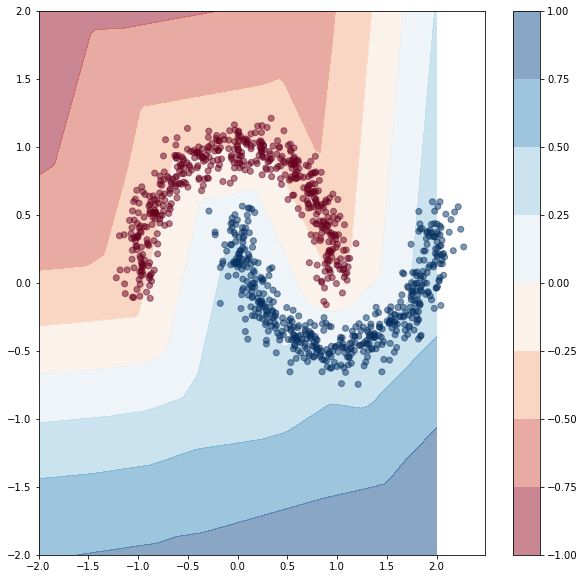

In [145]:
plot_mlp(mlp)

In [4]:
import torch
import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from monotonenorm import direct_norm, GroupSort
from torchvision import datasets, transforms

torch.manual_seed(42)

trainset = datasets.MNIST(root='/data/kitouni/datasets', train=True, download=True, transform=transforms.ToTensor())
x = trainset.data.float() / 255
y = trainset.targets
valset = datasets.MNIST(root='/data/kitouni/datasets', train=False, download=True, transform=transforms.ToTensor())
x_val = valset.data.float() / 255
y_val = valset.targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x = x.flatten(1).to(device)
y = torch.nn.functional.one_hot(y).to(device)

x_val = x_val.flatten(1).to(device)
y_val = torch.nn.functional.one_hot(y_val).to(device)

class Model(ModelBase):
    def __init__(self, lipschitz=True, seed=None, width=256):
        if seed is not None: torch.manual_seed(seed)
        super().__init__()
        norm = direct_norm if lipschitz else lambda x, **kwargs: x
        act = GroupSort(width//2) if lipschitz else torch.nn.ReLU()

        self.mlp = torch.nn.Sequential(
            norm(torch.nn.Linear(28*28, width), kind="two-inf"),
            act,
            norm(torch.nn.Linear(width, width), kind="inf"),
            act,
            norm(torch.nn.Linear(width, 10), kind="inf"))
        self.mlp.to(device)
        self.loss = CELoss() 

    def set_loss(self, loss):
        self.loss = loss

In [6]:
model = Model(lipschitz=True, seed=0).to(device)
loss = CELoss(tau=1)
model.set_loss(loss)
model.train_loop(epochs=2000, lr=1e-3)

  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [4]:
d_margins = label_dist(x.cpu(), y.cpu(), p=2)

In [5]:
model = Model(lipschitz=True, seed=0)
loss = DynamicHingeLoss(x=x, y_true=y, p=2, margin=1, reduction='mean', d_margins=d_margins/2).to(device)
model.set_loss(loss)
model.train_loop(epochs=2000, lr=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [168]:
model = Model(lipschitz=True, seed=0)
loss = HKRLoss(margin=0.1, alpha=100)
model.set_loss(loss)
model.train_loop(epochs=2000, lr=1e-3)

100%|██████████| 2000/2000 [01:44<00:00, 19.09it/s, acc=0.971, loss=-2.71, max_margin=14.5, mean_margin=1.76, min_margin=2.38e-7, ypred=-1.86]  
